In [1]:
import pandas as pd
import numpy as np
import random 
from pprint import pprint as pp
from time import time, sleep
import multiprocessing as mp
from multiprocessing import Process, Pipe
from tqdm import tqdm

import joblib


from multiprocessing import Process, Pipe
from sentence_transformers import SentenceTransformer
from gensim.summarization.textcleaner import get_sentences
import lightgbm as lgb
from time import sleep
BASE_SAGEMAKER_PATH = "/Users/abanerjee4/Projects/Deploy/proto_1/abanerjee4/model"
import os
dbert_path = os.path.join(BASE_SAGEMAKER_PATH,"distilbert-base-nli-mean")
dbert = SentenceTransformer(dbert_path)

In [20]:
test_df = pd.read_csv("./data/test.csv")

In [5]:
keu = pd.read_excel("./data/dashbotUtterances.xlsx",sheet_name='keUtterances')["Text"]
fp = pd.read_excel("./data/dashbotUtterances.xlsx",sheet_name='false positive') ["where do i calculate estimated 2018 taxes"]
sh = pd.read_excel("./data/dashbotUtterances.xlsx",sheet_name='Self Help') ["how do I edit my email address"]
gtd = pd.read_excel("./data/dashbotUtterances.xlsx",sheet_name='general test data') 

In [8]:
train_pos = keu.to_list()
flag = [1 for x in train_pos]
train_neg = fp.to_list()+sh.to_list()
flag = flag + [0 for x in train_neg]

In [13]:
train_df = pd.DataFrame(columns=["Text","KE"])
train_df["Text"] = train_pos+train_neg
train_df["KE"] = flag
#train_df.to_csv("./data/train.csv",index=None)

In [12]:
train_df.sample(5)

,Text,KE
68,state compute penalty box,0
22,Why is my filing status Single?,1
38,Do I owe self-employment tax,1
11,why do I owe <amount>,1
103,meal deduction,0


In [804]:
len(train_df)

180

In [15]:
import re
def putPlaceHolder(query):
    #kw_list = ["how did", "how to"]
    #convert $ amount to "money" for inducing genericity
    query = re.sub(r"[\$]{1}[\d,]+\.?\d{0,2}|<amount>","money",query)
    #query = re.sub('|'.join("((?<=\s)|(?<=^)){}((?=\s)|(?=$))".format(i) for i in kw_list),"<kw>",query)
    return query

In [18]:
train_enc=dbert.encode(train_df["Text"].apply(lambda x: putPlaceHolder(x.lower())).astype(str).tolist(), batch_size = 8, show_progress_bar=True)

Batches: 100%|██████████| 23/23 [00:01<00:00, 20.79it/s]


In [21]:
test_enc=dbert.encode(test_df["text"].apply(lambda x: putPlaceHolder(x.lower())).astype(str).tolist(), batch_size = 8, show_progress_bar=True)

Batches: 100%|██████████| 106/106 [00:03<00:00, 31.74it/s]


In [820]:
test_enc[0]

array([-3.37695867e-01,  1.03301741e-01,  8.52186859e-01, -4.45880443e-01,
       -2.29933053e-01,  2.60718465e-01, -1.24143317e-01,  7.18120039e-01,
       -4.58950326e-02, -8.57877851e-01, -1.81492880e-01,  5.21643400e-01,
       -3.21515799e-02, -2.85080105e-01, -1.87429994e-01, -8.32997859e-01,
       -9.43647981e-01, -1.71602756e-01, -1.49579242e-01,  2.27258801e-01,
        1.56699032e-01,  5.64915657e-01,  8.15184116e-02,  5.09646535e-01,
       -5.23710325e-02,  1.33923352e-01,  1.30547309e+00, -6.25983298e-01,
       -8.91496763e-02,  3.15344214e-01,  2.30125710e-01, -6.96853876e-01,
       -2.53456801e-01, -6.14856124e-01, -4.57295358e-01, -8.12553942e-01,
        3.84595543e-02, -3.33569556e-01, -1.94906044e+00, -5.87516651e-02,
        1.75586313e-01,  4.67338860e-01,  5.83586991e-01, -6.33449733e-01,
        1.99175313e-01, -2.22305521e-01,  1.69995055e-01,  7.89812684e-01,
       -3.54014188e-01, -7.00805485e-01, -1.24628127e+00, -5.07493675e-01,
       -9.53433156e-01,  

In [543]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn import metrics

In [22]:
train_label = train_df["KE"]

In [209]:
X_train, X_test, y_train, y_test = train_test_split(
    train_enc, train_label, test_size=0.3, random_state=int(time()),stratify=train_label)

In [210]:
clf = RandomForestClassifier(max_depth=8, n_estimators = 32, random_state=0, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=32,
                       n_jobs=None, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [211]:
y_pred = clf.predict(X_test)
y_proba = [x[1] for x in clf.predict_proba(X_test)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


In [212]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84        35
           1       0.88      0.37      0.52        19

    accuracy                           0.76        54
   macro avg       0.81      0.67      0.68        54
weighted avg       0.79      0.76      0.73        54



In [213]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_proba)
metrics.auc(fpr, tpr)

0.906766917293233

In [374]:
auc = []
for i in tqdm(range(500)):
    X_train, X_test, y_train, y_test = train_test_split(
    train_enc, train_label, test_size=0.3, random_state=int(time()),stratify=train_label)
    clf = RandomForestClassifier(max_depth=4, n_estimators = 32, random_state=0, verbose=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = [x[1] for x in clf.predict_proba(X_test)]
    fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_proba)
    auc.append(metrics.auc(fpr, tpr))
    sleep((1/(1 + np.exp(-int(time())%100))))

100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


In [375]:
np.mean(auc)

0.8881675143741707

In [376]:
np.min(auc)

0.8117647058823529

In [377]:
np.max(auc)

0.9533834586466166

In [788]:
clf = RandomForestClassifier(max_depth=8, n_estimators = 512, random_state=0, verbose=1, class_weight="balanced")
clf.fit(train_enc, train_label)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=512, n_jobs=None, oob_score=False,
                       random_state=0, verbose=1, warm_start=False)

In [724]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type="gbdt",n_estimators=256, class_weight={1:1,0:1}, num_leaves=32,  max_depth=-1,learning_rate=.1,\
                      reg_alpha=2)
model.fit(train_enc,train_label)


LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 1},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=256, n_jobs=-1, num_leaves=32,
               objective=None, random_state=None, reg_alpha=2, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [225]:
gtd

,Question,KE Question,DF_Is_KE_Question,KE
0,direct deposit,False,False,0
1,agi,False,False,0
2,both,False,False,0
3,schedule c,False,False,0
4,no,False,False,0
...,...,...,...,...
995,Do I have to pay city tax to the city of my co...,False,False,0
996,How can I tell if my property taxes were filed?,False,False,0
997,I am responsible for paying for my own expense...,True,False,1
998,how did you compute my deductible donations,True,True,1


In [226]:
gtd["KE"] = gtd["KE Question"].apply(lambda x: 0 if x == False else 1)

In [227]:
gtd_true = gtd["KE"]

In [228]:
gtd_ques = gtd["Question"]


In [229]:
gtd_ques_enc = dbert.encode(gtd_ques.apply(lambda x: putPlaceHolder(x.lower())).astype(str).tolist(), batch_size = 8, show_progress_bar=True)

Batches: 100%|██████████| 125/125 [00:04<00:00, 26.28it/s]


In [805]:
gtd_proba= [x[1] for x in clf.predict_proba(gtd_ques_enc)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.1s finished


In [781]:
# gtd_proba= [(x[0][1]+x[1][1])/2 for x in zip(clf.predict_proba(gtd_ques_enc),model.predict_proba(gtd_ques_enc))]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.1s finished


In [790]:
gtd_proba[:3]

[0.23790896907106426, 0.10989470233035845, 0.1522450083645507]

In [806]:
fpr, tpr, thresholds = metrics.roc_curve(gtd_true.values, gtd_proba)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9479847307242588


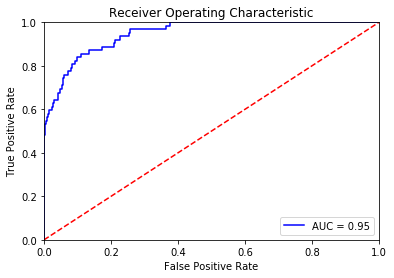

In [792]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/Users/abanerjee4/Projects/Deploy/proto_1/abanerjee4/envs/deploy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


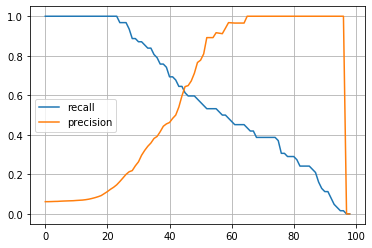

In [793]:
prec = []
rec = []
for perc in range(0,99):
    gtd_pred = [1 if x > perc/100.0 else 0 for x in gtd_proba]
    rec.append(precision_recall_fscore_support(gtd_true.values, gtd_pred)[1][1])
    prec.append(precision_recall_fscore_support(gtd_true.values, gtd_pred)[0][1])

pr_df = pd.DataFrame()
pr_df["recall"] = rec
pr_df["precision"] = prec
pr_df.plot(grid=True)

In [807]:
gtd_pred = [1 if x > 0.5 else 0 for x in gtd_proba]
print(classification_report(gtd_true.values, gtd_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       938
           1       0.78      0.56      0.65        62

    accuracy                           0.96      1000
   macro avg       0.87      0.78      0.82      1000
weighted avg       0.96      0.96      0.96      1000



In [251]:
sp_df = pd.read_csv("./data/Splunk_TDA_data_full - CalcQuestions.csv")

In [252]:
sp_df.sample(5)

,Question,KE Question
228,"""turbotax isn't calculating my dependencies""; \n",False
47,"""How was my state tax calculated""; \n",True
220,"""The program is not calculating my entries cor...",False
117,"""how to calculate my premium percentage""; \n",True
115,"""how is tax due calculated""; \n",True


In [253]:
sp_df["KE"] = sp_df["KE Question"].apply(lambda x: 0 if x == False else 1)

In [254]:
sp_df.head()

,Question,KE Question,KE
0,"""Turbotax calculated my tax rate wrong""; \n",True,1
1,"""TurboTax calculated my taxes to be <amount> #...",True,1
2,"""why do we not qualify for Vermont Property Ta...",True,1
3,"""Why does my summary page list a different amo...",True,1
4,"""'Total #### Tax Due amount is different than ...",True,1


In [255]:
sp_true = sp_df["KE"]

In [352]:
sp_enc = dbert.encode(sp_df["Question"].apply(lambda x: putPlaceHolder(x.lower())).astype(str).tolist(), batch_size = 8, show_progress_bar=True)

Batches: 100%|██████████| 43/43 [00:04<00:00, 10.13it/s]


In [795]:
sp_proba= [x[1] for x in clf.predict_proba(sp_enc)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.1s finished


In [ ]:
# sp_proba= [(x[0][1]+x[1][1])/2 for x in zip(clf.predict_proba(sp_enc),model.predict_proba(sp_enc))]

In [813]:
sp_pred = [1 if x > 0.5 else 0 for x in sp_proba]
print(classification_report(sp_true.values, sp_pred))

              precision    recall  f1-score   support

           0       0.70      0.97      0.82       216
           1       0.85      0.27      0.41       121

    accuracy                           0.72       337
   macro avg       0.78      0.62      0.61       337
weighted avg       0.76      0.72      0.67       337



In [798]:
fpr, tpr, thresholds = metrics.roc_curve(sp_true.values, sp_proba)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7451025405570859


In [814]:
sp_df["pred"] = sp_pred

In [819]:
sp_df[(sp_df["pred"] == 0) & (sp_df["KE"] == 1)].sample()["Question"].values

array(['"how did you calc my il tax due"; \n'], dtype=object)

In [815]:
sp_df.groupby(["KE","pred"]).count()

Question  KE Question
KE pred                       
0  0          210          210
   1            6            6
1  0           88           88
   1           33           33